# RNN Based molecule generation

Laurent Cetinsoy

In this hands-on we want to generate molecule formulas for denovo-drug discovery.

For that we need to use Generative models. Generative models are models which goes beyond classification or simple regression : they are able to generate data that look like previously seens dataset.

There exists a lot of models :

- Bayesian models like graphical models
- Recurrent models (for sequence generation like texte)
- Variational auto encoders
- Generative adversarial models
- Flow and diffusion models


In the hands-on we will start by  trainning a character based RNN to generate smile molecules


We want to feed smile representations of molecules to an RNN.
The basic idea is we will train it to predict the next smile token of a molecule given the previous one.

For instance for the following molecule "CC(=O)NC1=CC=C(O)C=C1" will may give to the model

X = "CC(=O)N"
y = C

and ask the RNN to learn to predict y given X

Like a standard language model !


## RNN Language model


A language model is a model which predict the next token of a sequence given the previous ones :

$ P(X_t | X_{t-1}, X_{t-2}, ..., X_{t-p})  $


This model can be learned with a Recurrent neural network

$ y = P(X_t | X_{t-1}, X_{t-2}, ..., X_{t-p}) = RNN_{\theta} (X_{t-1}, X_{t-2}, ..., X_{t-p})  $


In order to train such model you need a corpus of data.



There are two main ways to do that : Word level model or character level model

For character level models, an interesting resource is : http://karpathy.github.io/2015/05/21/rnn-effectiveness/



Explain briefly what is the difference between word based language model and character based language model

Word-based models tokenize at the word level, so each token represents a complete word. Vocabulary size is large (thousands of words) but sequences are shorter. They can't generate new words outside the vocabulary.

Character-based models work at the character level - each character is a token. Vocabulary is small (~50-100 chars) but sequences are much longer. They can generate any word and handle rare words better, but need more computation.

In [1]:
import os

# Comme TensorFlow est vraiment pas ouf il faut le dire, je met pytorch qui lui supporte mon gpu rtx 5070 ti :)
os.environ["KERAS_BACKEND"] = "torch"

import keras
print("Backend utilisé :", keras.backend.backend()) 

import torch
print("GPU dispo :", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Carte :", torch.cuda.get_device_name(0))

Backend utilisé : torch
GPU dispo : True
Carte : NVIDIA GeForce RTX 5070 Ti Laptop GPU


/home/leo/Bureau/mlbio_tps/.venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## Loading the data

Dowload the following dataset : https://github.com/joeymach/Leveraging-VAE-to-generate-molecules

In [2]:
import urllib.request
import os

url = "https://raw.githubusercontent.com/joeymach/Leveraging-VAE-to-generate-molecules/master/250k_smiles.csv"
filename = "250k_smiles.csv"

if not os.path.exists(filename):
    urllib.request.urlretrieve(url, filename)
    print("Downloaded")
else:
    print("Already exists")

Already exists


Import pandas and load the first 1000 lines

In [3]:
import pandas as pd

df = pd.read_csv('250k_smiles.csv', nrows=1000)
print(f"Loaded {len(df)} molecules")

Loaded 1000 molecules


Display the first rows of the dataframe

In [4]:
df.head()

,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


## Processing the data

We need to do the following things :

- convert smile tokens to numbers
- build  smile token sequences and corresponding labels pairs

Compute the biggest smile molecule size

In [5]:
max_len = df['smiles'].str.len().max()
print(f"Max length: {max_len}")

Max length: 106



Code a function **unic_characters(string)** which return the unic characters in a string


In [6]:
def unic_characters(string):
    return sorted(set(string))

Concatenate all smile string of the pandas dataframe and use **unic_characters** to get the unic_characters

In [7]:
all_smiles = ''.join(df['smiles'].values)
unique_chars = unic_characters(all_smiles)
print(f"Unique characters: {len(unique_chars)}")
print(unique_chars)

Unique characters: 33
['\n', '#', '(', ')', '+', '-', '/', '1', '2', '3', '4', '5', '6', '7', '=', '@', 'B', 'C', 'F', 'H', 'I', 'N', 'O', 'S', '[', '\\', ']', 'c', 'l', 'n', 'o', 'r', 's']


Code a function **map_char_to_int(unic_chars)** which returns a dictionnary where each char is assigned an int value.
Add a character to specify the end of the molecule (like "\n")


In [8]:
def map_char_to_int(unic_chars):
    char_to_int = {char: i for i, char in enumerate(unic_chars)}
    char_to_int['\n'] = len(unic_chars)
    return char_to_int

char_to_int = map_char_to_int(unique_chars)
print(f"Vocabulary size: {len(char_to_int)}")


Vocabulary size: 33


Code a function map_int_to_char(unic_chars) which returns the reverse mapping.

If you want you can merge both functions in a class

In [9]:
def map_int_to_char(unique_chars):
    int_to_char = {i: char for i, char in enumerate(unique_chars)}
    int_to_char[len(unique_chars)] = '\n'
    return int_to_char

int_to_char = map_int_to_char(unique_chars)


For each smile molecule add the ending token to it

In [10]:
df['smiles'] = df['smiles'] + '\n'
print(df['smiles'].iloc[0])


CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1




## Building the dataset

Now we will create the dataset so that it has the good share for our Keras LSTM model

Remember Keras recurrent models expect a 3D array with shapes (n_examples, seq_len, n_features)



What will be n_features in our case ?

Code a function **build_X_and_y(string, i_char, seq_lenght)** which takes a string, a **seq_length** number and a position.


It should create X by by getting all character between i and i + seq_length
and create y by getting the character following the X sequence
it returns X and y

Test your function on the following string "" with seq_length = 4 and i = [1, 2, 3]

In [11]:
def build_X_and_y(string, i_char, seq_length):
    X = string[i_char:i_char + seq_length]
    y = string[i_char + seq_length]
    return X, y

test_string = "CC(=O)NC1=CC=C(O)C=C1\n"
seq_length = 4

for i in [1, 2, 3]:
    X, y = build_X_and_y(test_string, i, seq_length)
    print(f"i={i}: X='{X}', y='{y}'")


i=1: X='C(=O', y=')'
i=2: X='(=O)', y='N'
i=3: X='=O)N', y='C'


By using build_X_and_y and map_char_to_int build a list nameed X_train and a list named y_train

In [12]:
seq_length = 50
X_train = []
y_train = []

for smiles in df['smiles'].values:
    for i in range(len(smiles) - seq_length):
        X, y = build_X_and_y(smiles, i, seq_length)
        X_train.append([char_to_int[char] for char in X])
        y_train.append(char_to_int[y])

print(f"Created {len(X_train)} training examples")


Created 2007 training examples


Create numpy arrays from the lists

In [13]:
import numpy as np

X_train = np.array(X_train)
y_train = np.array(y_train)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


X_train shape: (2007, 50)
y_train shape: (2007,)


Reshape the X numpy array (n_examples, seq_lenght, 1)

In [14]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
print(f"X_train shape after reshape: {X_train.shape}")


X_train shape after reshape: (2007, 50, 1)


Normalize X by dividing each values by the total number of unic characters

In [15]:
n_chars = max(char_to_int.values()) + 1
X_train = X_train.astype(float) / n_chars
print(f"X_train normalized, range: [{X_train.min():.3f}, {X_train.max():.3f}]")
print(f"n_chars: {n_chars}, y_train range: [{y_train.min()}, {y_train.max()}]")


X_train normalized, range: [0.029, 0.971]
n_chars: 34, y_train range: [2, 33]


Import Keras and build (at least) a two layered LSTM network with 128 neurone in each.

You can also add Dropoutlayers

Do you think you should use the return_sequences = True ? If yes, when ?


Add a Dense layer on top with with the appropriate activation function and number of neurones


In [16]:
import keras
from keras import layers
import numpy as np

n_classes = int(np.max(y_train) + 1)

model = keras.Sequential([
    layers.LSTM(256, input_shape=(seq_length, 1)), 
    layers.Dense(n_classes, activation='softmax')
])

model.summary()

/home/leo/Bureau/mlbio_tps/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 34)             │         8,738 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 272,930 (1.04 MB)

 Trainable params: 272,930 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

Compile the model with the appropriate loss function and the adam optimizer

In [17]:
from keras.optimizers import Adam
from keras.utils import to_categorical

y_train_cat = to_categorical(y_train, num_classes=n_classes)

model.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.002, clipnorm=1.0), 
    metrics=['accuracy']
)

Train the model on 20 epochs and 10 examples (yeah you read correctly) and check that the model overfits !

In [18]:
X_small = X_train[:10]
y_small = y_train_cat[:10]

history = model.fit(X_small, y_small, epochs=200, batch_size=10, verbose=1, shuffle=False)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.0000e+00 - loss: 3.5301
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3000 - loss: 3.4107
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.3000 - loss: 3.1962
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3000 - loss: 2.2238
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3000 - loss: 2.1026
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2000 - loss: 1.8613
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2000 - loss: 1.8444
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2000 - loss: 1.7872
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3000 - loss: 1.7605
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3000 - loss: 1.7718
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3000 - loss: 1.7573
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.300

If it does not overfit try to fix data prep and model architecture so it does

In [19]:
print("it does overfit")


it does overfit


Create a function **make_prediction(seed_start)** which takes a starting string sequence and uses it to generate a molecule


In [20]:
def make_prediction(seed_start, model, n_chars, char_to_int, int_to_char, seq_length=50, max_length=100):
    molecule = seed_start
    seed = seed_start[-seq_length:] if len(seed_start) >= seq_length else seed_start
    
    pad_char = list(char_to_int.keys())[0]
    for _ in range(max_length):
        if len(seed) < seq_length:
            current_seed = pad_char * (seq_length - len(seed)) + seed
        else:
            current_seed = seed[-seq_length:]
        
        x = np.array([[char_to_int[char] for char in current_seed]])
        x = x.reshape((1, seq_length, 1))
        x = x.astype(float) / n_chars
        
        pred = model.predict(x, verbose=0)
        pred_idx = np.argmax(pred[0])
        next_char = int_to_char[pred_idx]
        
        if next_char == '\n':
            break
            
        molecule += next_char
        seed += next_char
    
    return molecule


generate a molecule of your overfitted model

In [21]:
seed = "CC(=O)N"
generated = make_prediction(seed, model, n_chars, char_to_int, int_to_char)
print(f"Generated molecule: {generated}")


Generated molecule: CC(=O)NccC3cc)C3ccC


Make a model checkpoint so that the model is saved after each epoch
if you train on a plateform and it stops you do not lose your training

In [22]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('best_model.keras', monitor='loss', save_best_only=True, verbose=1)

Now go to your favorite plateform (colab or something else) and train the dataset on the whole data for 10 epochs and batch size 256

it should take a long time so either follow the class or go take a nap

In [23]:
df_full = pd.read_csv('250k_smiles.csv')
df_full['smiles'] = df_full['smiles'] + '\n'

all_smiles_full = ''.join(df_full['smiles'].values)
unique_chars_full = unic_characters(all_smiles_full)
char_to_int_full = map_char_to_int(unique_chars_full)
int_to_char_full = map_int_to_char(unique_chars_full)

X_train_full = []
y_train_full = []

for smiles in df_full['smiles'].values:
    for i in range(len(smiles) - seq_length):
        X, y = build_X_and_y(smiles, i, seq_length)
        X_train_full.append([char_to_int_full[char] for char in X])
        y_train_full.append(char_to_int_full[y])

X_train_full = np.array(X_train_full).reshape((len(X_train_full), seq_length, 1))
n_chars_full = max(char_to_int_full.values()) + 1
X_train_full = X_train_full.astype(float) / n_chars_full
y_train_full_cat = to_categorical(y_train_full, num_classes=n_chars_full)

In [24]:
import os

if os.path.exists('best_model.keras'):
    print("best_model.keras found, loading existing model.")
    model_full = keras.models.load_model('best_model.keras')
else:
    print("No saved model found. Training new model...")
    model_full = keras.Sequential([
        layers.LSTM(128, return_sequences=True, input_shape=(seq_length, 1)),
        layers.Dropout(0.2),
        layers.LSTM(128, return_sequences=False),
        layers.Dropout(0.2),
        layers.Dense(n_chars_full, activation='softmax')
    ])
    model_full.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    checkpoint = ModelCheckpoint('best_model.keras', monitor='loss', save_best_only=True, verbose=1)
    model_full.fit(X_train_full, y_train_full_cat, epochs=10, batch_size=256, callbacks=[checkpoint], verbose=1)


best_model.keras found, loading existing model.


Generate between 100 and 1000 molecules.

create a list where molecules have between 10 and 50 atoms

In [25]:
import numpy as np
from rdkit import Chem, RDLogger

RDLogger.DisableLog('rdApp.*') 

def sample(preds, temperature=0.4):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-7) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

seeds = df_full['smiles'].sample(200).values
seeds = [s[:15] for s in seeds]

generated_molecules = []
target_n = 100
tries = 0

print("--- Lancement de la génération par amorçage (Priming) ---")

while len(generated_molecules) < target_n and tries < len(seeds):
    seed_str = seeds[tries]
    tries += 1
    
    generated = seed_str
    sentence = seed_str
    
    for _ in range(60):
        x_int = [char_to_int_full.get(c, 0) for c in sentence[-seq_length:]]
        if len(x_int) < seq_length:
            x_int = [0] * (seq_length - len(x_int)) + x_int
            
        x_input = np.array(x_int).reshape(1, seq_length, 1)
        x_input = x_input.astype(float) / n_chars_full
        
        preds = model_full.predict(x_input, verbose=0)[0]
        next_char = int_to_char_full[sample(preds, temperature=0.5)]
        
        if next_char == '\n':
            break
            
        generated += next_char
        sentence += next_char

    mol = Chem.MolFromSmiles(generated)
    if mol is not None:
        atom_count = mol.GetNumAtoms()
        if 10 <= atom_count <= 50:
            generated_molecules.append(generated)
            if len(generated_molecules) % 5 == 0:
                print(f"Trouvé {len(generated_molecules)}/{target_n}...")

print(f"\nFini ! {len(generated_molecules)} molécules valides.")

--- Lancement de la génération par amorçage (Priming) ---
Trouvé 5/100...
Trouvé 10/100...
Trouvé 15/100...

Fini ! 18 molécules valides.


With rdkit compute the Quantified Estimated Drug likelyness (QED) of each molecule in this subset

In [26]:
from rdkit import Chem
from rdkit.Chem import QED

qed_scores = []
valid_molecules = []

for mol_str in generated_molecules:
    try:
        mol = Chem.MolFromSmiles(mol_str)
        if mol is not None:
            qed = QED.qed(mol)
            qed_scores.append(qed)
            valid_molecules.append(mol_str)
    except:
        continue

print(f"Valid molecules: {len(valid_molecules)}/{len(generated_molecules)}")
print(f"Average QED: {np.mean(qed_scores):.3f}")
print(f"Best QED: {np.max(qed_scores):.3f}")


Valid molecules: 18/18
Average QED: 0.670
Best QED: 0.833


Bonus 1 : Using rdkit, compute the quantitative estimation of drug-likeness (QED) of your generated molecules.

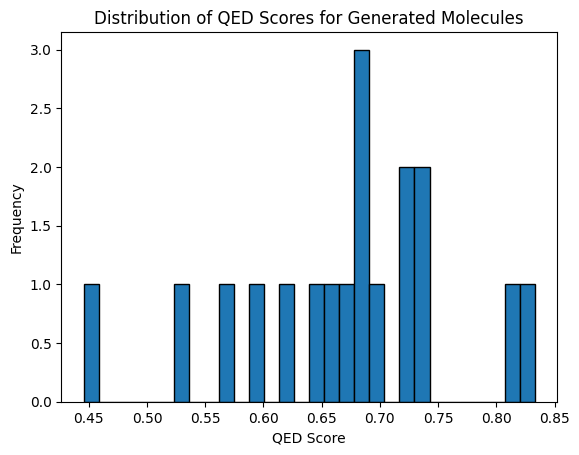

QED statistics:
Mean: 0.670
Std: 0.092
Min: 0.446
Max: 0.833


In [27]:
import matplotlib.pyplot as plt

plt.hist(qed_scores, bins=30, edgecolor='black')
plt.xlabel('QED Score')
plt.ylabel('Frequency')
plt.title('Distribution of QED Scores for Generated Molecules')
plt.show()

print(f"QED statistics:")
print(f"Mean: {np.mean(qed_scores):.3f}")
print(f"Std: {np.std(qed_scores):.3f}")
print(f"Min: {np.min(qed_scores):.3f}")
print(f"Max: {np.max(qed_scores):.3f}")


Bonus 2 : try to adapt a transformer model training from hugging face to see if it is better

In [28]:
from transformers import GPT2Config, GPT2LMHeadModel, GPT2TokenizerFast, DataCollatorForLanguageModeling, Trainer, TrainingArguments
from datasets import Dataset

# 1. Config du modèle (petit GPT-2 custom)
config = GPT2Config(
    vocab_size=len(char_to_int) + 1, # +1 pour le padding
    n_positions=128,
    n_ctx=128,
    n_embd=128,
    n_layer=2,
    n_head=4
)
model_hf = GPT2LMHeadModel(config)

# 2. Prépa des données "à la main" pour aller vite
# On transforme nos séquences d'entiers en dataset HuggingFace
dataset = Dataset.from_dict({"input_ids": X_train.squeeze().astype(int)})

# 3. Training arguments
args = TrainingArguments(
    output_dir="transformer_output",
    per_device_train_batch_size=32,
    num_train_epochs=3,
    learning_rate=1e-3,
    save_steps=500,
    logging_steps=100,
    use_cpu=False # Utilise ton GPU
)

trainer = Trainer(
    model=model_hf,
    args=args,
    train_dataset=dataset,
    data_collator=DataCollatorForLanguageModeling(tokenizer=None, mlm=False)
)

trainer.train()

AttributeError: 'NoneType' object has no attribute 'pad'